20210721
얼굴과 눈 검출, HSV 처리

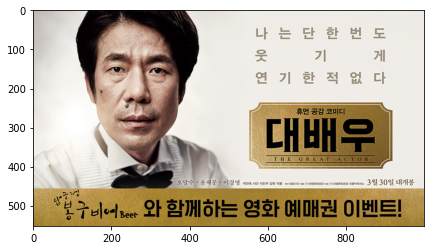

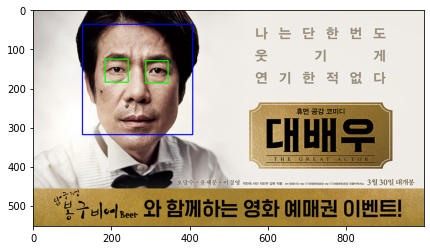

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.covariance import EllipticEnvelope

#얼굴분류기, 눈 분류기 불러오기
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# 이미지 파일 불러오기
img = cv2.imread('test.jpg')

# 이미지 출력하기  
plt.figure(figsize=(7,10))
plt.imshow(img[:,:,::-1]) 
plt.show()

# 이미지에서 얼굴 찾기

faces = face_cascade.detectMultiScale(img, scaleFactor= 1.1, minNeighbors=5)

temp = img.copy()
for (x,y,w,h) in faces:
 # 얼굴 바운딩박스 그리기
    cv2.rectangle(temp,(x,y),(x+w,y+h),(255,0,0),2)
    roi_color = temp[y:y+h, x:x+w]
 # 얼굴에서 눈 찾기
    eyes = eye_cascade.detectMultiScale(roi_color, scaleFactor= 1.1, minNeighbors=5)
    for (ex,ey,ew,eh) in eyes:
 # 눈 바운딩 박스 그리기
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
#이미지 출력하기
plt.figure(figsize=(7,10))
plt.imshow(temp[:,:,::-1])
plt.show()

In [5]:
#동공검출에 적용

# 영상을 이미지로 바꾸기
vidcap = cv2.VideoCapture('video_sample/pupil_video_1.mp4')
count = 1 
success = True
while success: 
    try:
        success,image = vidcap.read()
        cv2.imwrite("processed_data/data_0725/data_video_1/image{}.jpg".format(str(count).zfill(3)), image) # 이미지 포맷 저장
    #print("saved image %d.jpg" % count)
        count += 1
    except: 
        break
# Haar cascade를 이용해서 눈 찾기

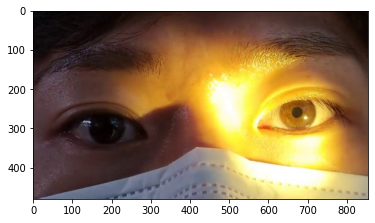

In [110]:
# 원본이미지
img = cv2.imread('data_0721/sample/image235.jpg') 
plt.imshow(img[:,:,::-1])

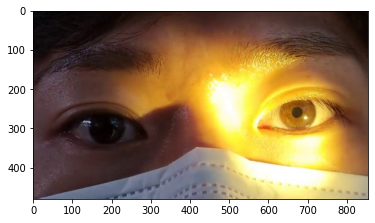

In [111]:
# 얼굴 찾기
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(img, scaleFactor= 1.1, minNeighbors=3)

temp = img.copy()

for (x,y,w,h) in faces: 
    cv2.rectangle(temp,(x,y),(x+w,y+h),(255,0,0),2)

# 눈 찾기
    eyes = eye_cascade.detectMultiScale(img, scaleFactor=1.1,minNeighbors=3) 
    temp = img.copy()
    for (x,y,w,h) in eyes:
 # 눈 바운딩 박스 그리기
        cv2.rectangle(temp,(x,y),(x+w,y+h),(0,255,0),4)

plt.imshow(temp[:,:,::-1])

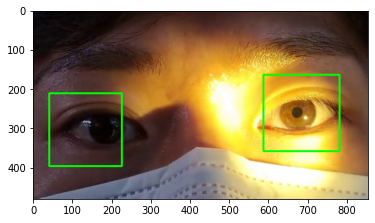

In [112]:
# 바운딩 박스의 폭이 가장 넓은 상위 2개의 박스만 찾기
eyes = eye_cascade.detectMultiScale(img) 
eyes = eyes[eyes[:,2].argsort()[-2:]] 
temp = img.copy()
for (x,y,w,h) in eyes:
 # 눈 바운딩 박스 그리기
    cv2.rectangle(temp,(x,y),(x+w,y+h),(0,255,0),4) 

plt.imshow(temp[:,:,::-1])

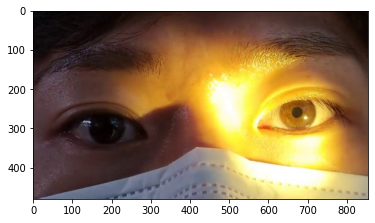

In [113]:
#HSV Color model을 이용해 빛이 있는 쪽의 눈(target eye) 찾기

# hsv 변환
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# 빛의 범위
lower_light = (0, 50, 200) 
upper_light = (255, 255, 255)

mask_light = cv2.inRange(img_hsv, lower_light, upper_light)

plt.imshow(mask_light, cmap='gray')


'''
바운딩박스의 x값이 이미지의 왼쪽에 있으면 왼쪽눈, 오른쪽에 있으면 오른쪽 눈으로 정의
바운딩박스 영역에서 빛이 비추는 비율(10%)이 일정 값 이상이고 비율이 큰쪽을 target_eye로 정의
'''
height, width = img.shape[:2]

x_l, y_l, w_l, h_l = eyes[eyes[:,0] < width//2].flatten()
x_r, y_r, w_r, h_r = eyes[eyes[:,0] > width//2].flatten()

left_value = np.sum(mask_light[y_l:y_l+h_l,x_l:x_l+w_l])/(w_l*h_l*255)
right_value = np.sum(mask_light[y_r:y_r+h_r,x_r:x_r+w_r])/(w_r*h_r*255)

temp = img.copy()
if (left_value>right_value):
    if left_value>0.1: 
        cv2.rectangle(temp,(x_l,y_l),(x_l+w_l,y_l+h_l),(0,255,0),4)
    else:
        if right_value>0.1:
            cv2.rectangle(temp,(x_r,y_r),(x_r+w_r,y_r+h_r),(0,255,0),4)
plt.imshow(temp[:,:,::-1])

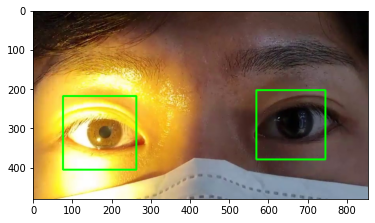

In [114]:
#2차 회의

'''
동공 경계 검출 방법
1. Haar cascade를 이용하여 눈 검출
2. HSV color model을 이용하여 빛이 있는 눈 선택
3. Erosion & Dilation을 이용하여 눈꼬리 제거
4. Sampling을 한 후 Robust Covariance Outlier Detection을 이용해 대략적인 각막의 중심 도출
5. MCD(Minimum Covariance Determinant) center를 기준으로 RoI 결정
6. Hough circle detection을 이용해 RoI 내에 MCD 중심과 가장 가까운 원을 동공의 경계로 정함
'''

# Haar cascade를 이용해서 눈 찾기

img = cv2.imread('data_0721/sample/image031.jpg')

eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
eyes = eye_cascade.detectMultiScale(img)
eyes = eyes[eyes[:,2].argsort()[-2:]]
temp = img.copy()
for (x,y,w,h) in eyes: 
    # 눈 바운딩 박스 그리기
    cv2.rectangle(temp,(x,y),(x+w,y+h),(0,255,0),4) 
plt.imshow(temp[:,:,::-1])

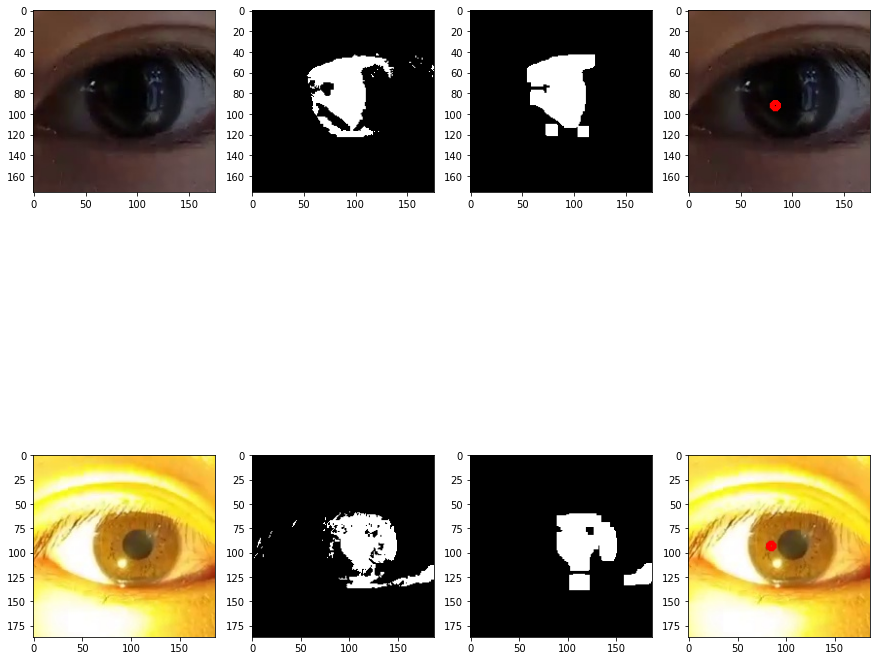

In [115]:
# MCD 중심 찾기
mcd_centers=[]
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,15)) 
for i, eye in enumerate(eyes):
    x,y,w,h = eye
    # 눈 이미지만 추출
    img_eye = img[y:y+h, x:x+w,:]
    ax[i,0].imshow(img_eye[:,:,::-1])
    img_gray = cv2.cvtColor(img_eye, cv2.COLOR_BGR2GRAY) 
    # img_gray = cv2.medianBlur(img_gray, 5) # 그레이스케일된 이미지 블로우처리
    # img_gray 10% threshold
    threshold = np.percentile(img_gray.flatten(), 10)
    _, binary = cv2.threshold(img_gray,threshold,255, cv2.THRESH_BINARY) 
    binary = 255-binary
    ax[i,1].imshow(binary, cmap='gray')

    binary = cv2.erode(binary, None, iterations=3)
    binary = cv2.dilate(binary, None, iterations=5) # (X,Y) 
    # binary = cv2.erode(binary, None, iterations=5) 
    ax[i,2].imshow(binary, cmap = 'gray')
    # 이진화 된 이미지에서 검은색 부분을 좌표로 바꿈
    temp=np.where(binary==0) 
    X=np.concatenate([[temp[0]], [temp[1]]]).T

    #Robust covariance, contamination:
    mcd = EllipticEnvelope(support_fraction = 0.6, contamination=0.4)

    if len(X)<3: 
        continue
    elif len(X)<300:
        y_pred = mcd.fit(X).predict(X)
    else:
        y_pred = mcd.fit(X[::100]).predict(X[::100])
  
    mcd_center = mcd.location_.astype(int)
    mcd_center=mcd_center[::-1]
    temp = img_eye.copy()
    cv2.circle(temp, (mcd_center[0],mcd_center[1]),3,(0,0,255),3) 
    ax[i,3].imshow(temp[:,:,::-1])
    mcd_centers.append(mcd_center+np.array([x,y]))

plt.show()

In [116]:
# 빛이 있는 눈의 MCD center를 중심으로 작은 RoI 찾기


def get_target_eye(img, mcd_centers, max_radious):
    mcd_centers = np.array(mcd_centers)

    height, width = img.shape[:2]
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    lower_light = (0, 50, 200) 
    upper_light = (255, 255, 255)
    
    mask_light = cv2.inRange(img_hsv, lower_light, upper_light)
    
    try:
        left_eye = mcd_centers[mcd_centers[:,0] < width//2].flatten()
        if len(left_eye)>2:
           left_eye=left_eye[:2]
        
        x,y = left_eye
        w = max_radious+10
        h=w
        left_value = np.sum(mask_light[max(0,y-h):min(y+h,height),max(0,x-w):min(x+w,width)])#코드가 짤려있어서 추가한부분입니다.
    except:
        # print('There is no left eye') left_eye = []
        left_value = 0
    try:
        right_eye = mcd_centers[mcd_centers[:,0] >= width//2].flatten() 
        if len(right_eye)>2:
            right_eye=right_eye[:2]
        x,y = right_eye
        w = max_radious+10
        h=w
        right_value = np.sum(mask_light[max(0,y-h):min(y+h,height),max(0,x-w):min(x+w,width)])
    except:
        # print('There is no right eye') right_eye = []
        right_value = 0
    threshold = (max_radious+10)**2*0.1*255
    
    if (left_value < threshold) & (right_value < threshold): 
        # print('Unlighted')
        return [], 2
    if left_value < right_value: 
        return right_eye, 1
    else:
        return left_eye, 0

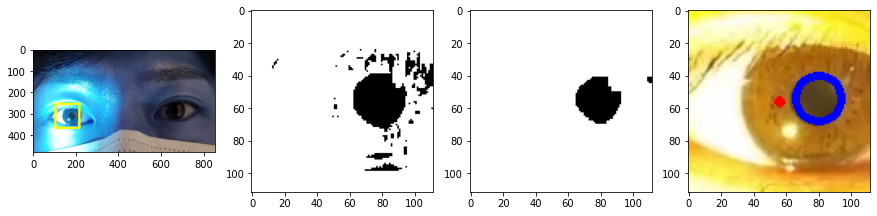

In [119]:
width, height = img.shape[:2]
max_radious = int(np.sqrt(width**2+height**2)//21)
target_eye, state = get_target_eye(img, mcd_centers, max_radious)
                                        
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

# MCD center
x = int(target_eye[0]) 
y = int(target_eye[1])
h = max_radious + 10 
w=h
                                        
# MCD center 중심으로 눈 RoI 결정
img_eye = img[max(0,y-h):min(y+h, img.shape[0]),max(0,x-w):min(x+w,img.shape[1]),:]
temp = img.copy()
cv2.rectangle(temp, (x-w,y-h),(x+w,y+h),(255,255,0), 10)
ax[0].imshow(temp)
img_gray = cv2.cvtColor(img_eye, cv2.COLOR_BGR2GRAY)
hsv_eye = cv2.cvtColor(img_eye, cv2.COLOR_BGR2HSV)

# 이진화
threshold = np.percentile(img_gray.flatten(), 10) # 하위 10% 값을 기준으로 이진화
_, binary = cv2.threshold(img_gray,threshold,255, cv2.THRESH_BINARY) 
ax[1].imshow(binary, cmap='gray') # 이진화 결과
binary = cv2.dilate(binary, None, iterations=3)
binary = cv2.erode(binary, None, iterations=1)
ax[2].imshow(binary, cmap='gray')# 전처리 결과
                                        
# Hough Circle Detection
circles = cv2.HoughCircles(binary, cv2.HOUGH_GRADIENT, 
                           dp = 1,
                           minDist = 100, 
                           param1=200,
                           param2=10, 
                           minRadius=int(max_radious*0.1), 
                           maxRadius=int(max_radious*0.6))
try:
    circles = np.uint16(np.around(circles)) 
    circles = circles[0][0]
except:
    # print("There is no pupil") 
    pass
temp = img_eye.copy()
cv2.circle(temp, (circles[0],circles[1]),circles[2],(255,0,0),3) 
cv2.circle(temp, (h,h),2, (0,0,255),2) 
ax[3].imshow(temp[:,:,::-1])
plt.show()  

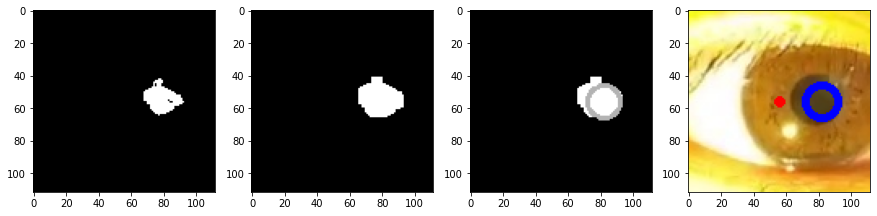

In [24]:
# 원에 내접하는 직사각형의 HSV color 평균값과 분산 구하기
length_ = int(circles[2]/(np.sqrt(2)*2))
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

hsv_candidate = hsv_eye[circles[1]-length_ :circles[1]+length_,circles[0]-length_:circles[0]]#잘못되었을 수도 있습니다. 
h_mean, h_std = np.mean(hsv_candidate[:,:,0]), np.std(hsv_candidate[:,:,0]) 
s_mean, s_std = np.mean(hsv_candidate[:,:,1]), np.std(hsv_candidate[:,:,1]) 
v_mean, v_std = np.mean(hsv_candidate[:,:,2]), np.std(hsv_candidate[:,:,2])
s=5
# 내접하는 사각형의 HSV color 범위
lower_bound = (h_mean-s*h_std, s_mean-s*s_std, v_mean-s*v_std) 
upper_bound = (h_mean+s*h_std, s_mean+s*s_std, v_mean+s*v_std)

# 위 범위에 해당하는 영역
img_mask = cv2.inRange(hsv_eye, lower_bound, upper_bound) 
ax[0].imshow(img_mask, cmap = 'gray')

# mask 전처리
img_mask = cv2.erode(img_mask, None, iterations=1) 
img_mask = cv2.dilate(img_mask, None, iterations=3) 
ax[1].imshow(img_mask, cmap = 'gray')
# mask에서 Hough circle detection
pupil = cv2.HoughCircles(img_mask, cv2.HOUGH_GRADIENT, dp = 1, minDist = 100, param1=200,param2=10, minRadius=int(max_radious*0.1), maxRadius=int(max_radious*0.6))
try:
    pupil = np.uint16(np.around(pupil)) 
    pupil = pupil[0][0]
except:
    # print("There is no pupil") 
    pass

cv2.circle(img_mask, (pupil[0],pupil[1]), pupil[2], 180,2) 
ax[2].imshow(img_mask, cmap = 'gray')
temp = img_eye.copy()
cv2.circle(temp, (pupil[0],pupil[1]),pupil[2],(255,0,0),3) 
cv2.circle(temp, (h,h),2, (0,0,255),2) 
ax[3].imshow(temp[:,:,::-1])
plt.show()

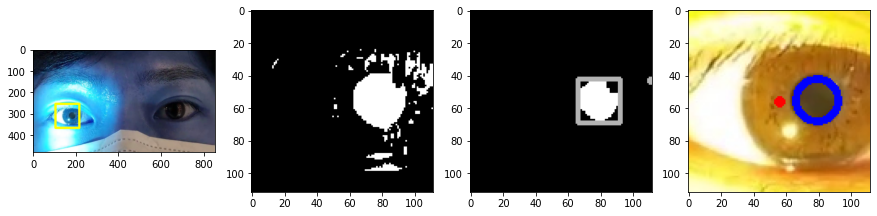

In [25]:
# Contour를 이용한 동공검출
width, height = img.shape[:2]
max_radious = int(np.sqrt(width**2+height**2)//21)
target_eye, state = get_target_eye(img, mcd_centers, max_radious)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
# MCD center
x = int(target_eye[0]) 
y = int(target_eye[1]) 
h = max_radious + 10 
w=h

# MCD center 중심으로 눈 RoI 결정
img_eye = img[max(0,y-h):min(y+h, img.shape[0]),max(0,x-w):min(x+w,img.shape[1]),:] 
temp = img.copy()
cv2.rectangle(temp, (x-w,y-h),(x+w,y+h),(255,255,0), 10)
ax[0].imshow(temp)

img_gray = cv2.cvtColor(img_eye, cv2.COLOR_BGR2GRAY) 
hsv_eye = cv2.cvtColor(img_eye, cv2.COLOR_BGR2HSV)

# 이진화
threshold = np.percentile(img_gray.flatten(), 10)# 하위10% 값을 기준으로 이진화
_, binary = cv2.threshold(img_gray,threshold,255, cv2.THRESH_BINARY) 
binary = 255-binary
ax[1].imshow(binary, cmap='gray')# 이진화 결과
binary = cv2.erode(binary, None, iterations=3)

# 이진화된 영역에서 contour 찾고 temp에 contour에 외접하는 직사각형 저장 
contours, hierarchy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
temp = []
for cnt in contours:
    x_c, y_c, w_c, h_c = cv2.boundingRect(cnt)
    cv2.rectangle(binary, (x_c, y_c), (x_c + w_c, y_c + h_c), 180, 2) 
    if x_c==0:
        continue
    temp.append([x_c, y_c, w_c, h_c])
# contour에 외접하는 직사각형 중 높이가 가장 큰 직사각형의 중심과 높이를 선택
temp = np.array(temp)
max_h = max(temp[:,3])
index = np.where(temp[:,3]==max_h)

x_c, y_c= temp[:,:2][index[0][0]].flatten()
w_c = max_h
h_c = max_h
circles = [int(x_c+max_h/2),int(y_c+max_h/2),int(max_h/2)]
ax[2].imshow(binary, cmap='gray')# 전처리 결과
cv2.circle(img_eye, (circles[0],circles[1]),circles[2],(255,0,0),3) 
cv2.circle(img_eye, (h,h),2, (0,0,255),2) 
ax[3].imshow(img_eye[:,:,::-1])
plt.show()                 

## Pupil Detection and Video Reconstruction

In [1]:
'''
라이브러리 세팅
'''
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.covariance import EllipticEnvelope

In [2]:
def eye_box(img):    
# Haar cascade를 이용해서 눈 찾기
# img: 눈이 포함된 이미지

    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    eyes = eye_cascade.detectMultiScale(img)
    eyes = eyes[eyes[:,2].argsort()[-2:]]
    temp = img.copy()
    for (x,y,w,h) in eyes: 
        # 눈 바운딩 박스 그리기
        cv2.rectangle(temp,(x,y),(x+w,y+h),(0,255,0),4) 
    
    return eyes # 얻어낸 박스들 출력

In [3]:
def MCD_centering(eyes):
    # MCD 중심 찾기
    mcd_centers=[]

    for i, eye in enumerate(eyes):
        x,y,w,h = eye
        # 눈 이미지만 추출
        img_eye = img[y:y+h, x:x+w,:]
        img_gray = cv2.cvtColor(img_eye, cv2.COLOR_BGR2GRAY) 
        # img_gray = cv2.medianBlur(img_gray, 5) # 그레이스케일된 이미지 블러링
        # img_gray 10% threshold
        threshold = np.percentile(img_gray.flatten(), 10)
        _, binary = cv2.threshold(img_gray,threshold,255, cv2.THRESH_BINARY) 
        binary = 255-binary

        binary = cv2.erode(binary, None, iterations=3)
        binary = cv2.dilate(binary, None, iterations=5) # (X,Y) 
        # binary = cv2.erode(binary, None, iterations=5) 

        # 이진화 된 이미지에서 검은색 부분을 좌표로 바꿈
        temp=np.where(binary==0) 
        X=np.concatenate([[temp[0]], [temp[1]]]).T

        #Robust covariance, contamination:
        mcd = EllipticEnvelope(support_fraction = 0.6, contamination=0.4)

        if len(X)<3: 
            continue
        elif len(X)<300:
            y_pred = mcd.fit(X).predict(X)
        else:
            y_pred = mcd.fit(X[::100]).predict(X[::100])

        mcd_center = mcd.location_.astype(int)
        mcd_center=mcd_center[::-1]
        temp = img_eye.copy()
        cv2.circle(temp, (mcd_center[0],mcd_center[1]),3,(0,0,255),3) 

        mcd_centers.append(mcd_center+np.array([x,y]))

    return mcd_centers #MCD 중심 반환

In [4]:
# 빛이 있는 눈의 MCD center를 중심으로 작은 RoI 찾기


def get_target_eye(img, mcd_centers, max_radious):
    mcd_centers = np.array(mcd_centers)

    height, width = img.shape[:2]
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    lower_light = (0, 50, 200) 
    upper_light = (255, 255, 255)
    # HSV 밝기 범위 지정
    mask_light = cv2.inRange(img_hsv, lower_light, upper_light)
    
    try:
        left_eye = mcd_centers[mcd_centers[:,0] < width//2].flatten()
        if len(left_eye)>2:
           left_eye=left_eye[:2]
        
        x,y = left_eye
        w = max_radious+10
        h=w
        left_value = np.sum(mask_light[max(0,y-h):min(y+h,height),max(0,x-w):min(x+w,width)])#코드가 짤려있어서 추가한부분입니다.
    except:
        # print('There is no left eye') left_eye = []
        left_value = 0
    try:
        right_eye = mcd_centers[mcd_centers[:,0] >= width//2].flatten() 
        if len(right_eye)>2:
            right_eye=right_eye[:2]
        x,y = right_eye
        w = max_radious+10
        h=w
        right_value = np.sum(mask_light[max(0,y-h):min(y+h,height),max(0,x-w):min(x+w,width)])
    except:
        # print('There is no right eye') right_eye = []
        right_value = 0
    threshold = (max_radious+10)**2*0.1*255
    
    if (left_value < threshold) & (right_value < threshold): 
        # print('Unlighted')
        return [], 2
    if left_value < right_value: 
        return right_eye, 1
    else:
        return left_eye, 0

In [5]:
def MCD_bright_centering(img,mcd_centers):
    width, height = img.shape[:2]
    max_radious = int(np.sqrt(width**2+height**2)//21)
    target_eye, state = get_target_eye(img, mcd_centers, max_radious)

    # MCD center
    x = int(target_eye[0]) 
    y = int(target_eye[1])
    h = max_radious + 10 
    w=h

    # MCD center 중심으로 눈 RoI 결정
    img_eye = img[max(0,y-h):min(y+h, img.shape[0]),max(0,x-w):min(x+w,img.shape[1]),:]
    temp = img.copy()
    cv2.rectangle(temp, (x-w,y-h),(x+w,y+h),(255,255,0), 10)

    img_gray = cv2.cvtColor(img_eye, cv2.COLOR_BGR2GRAY)
    hsv_eye = cv2.cvtColor(img_eye, cv2.COLOR_BGR2HSV)

    # 이진화
    threshold = np.percentile(img_gray.flatten(), 10) # 하위 10% 값을 기준으로 이진화
    _, binary = cv2.threshold(img_gray,threshold,255, cv2.THRESH_BINARY) 
    ax[1].imshow(binary, cmap='gray') # 이진화 결과
    binary = cv2.dilate(binary, None, iterations=3)
    binary = cv2.erode(binary, None, iterations=1)


    # Hough Circle Detection
    circles = cv2.HoughCircles(binary, cv2.HOUGH_GRADIENT, 
                               dp = 1,
                               minDist = 100, 
                               param1=200,
                               param2=10, 
                               minRadius=int(max_radious*0.1), 
                               maxRadius=int(max_radious*0.6))
    pupil_sensor=1
    try:
        circles = np.uint16(np.around(circles)) 
        circles = circles[0][0]
    except:
        # print("There is no pupil")
        pupil_sensor=0
        pass
    temp = img_eye.copy()
    cv2.circle(temp, (circles[0],circles[1]),circles[2],(255,0,0),3) 
    cv2.circle(temp, (h,h),2, (0,0,255),2) 
    if pupil_sensor==1:
        return hsv_eye,circles
    else:
        return None, None
 

In [6]:
def MCD_HSV(hsv_eye,circles):
    
    # eye_box가 있는가? 아니라면 코드 종결 
    if hsv_eye.all()==None:
        return None
    else:

        # 원에 내접하는 직사각형의 HSV color 평균값과 분산 구하기
        length_ = int(circles[2]/(np.sqrt(2)*2))
        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

        hsv_candidate = hsv_eye[circles[1]-length_ :circles[1]+length_,circles[0]-length_:circles[0]]#잘못되었을 수도 있습니다. 
        h_mean, h_std = np.mean(hsv_candidate[:,:,0]), np.std(hsv_candidate[:,:,0]) 
        s_mean, s_std = np.mean(hsv_candidate[:,:,1]), np.std(hsv_candidate[:,:,1]) 
        v_mean, v_std = np.mean(hsv_candidate[:,:,2]), np.std(hsv_candidate[:,:,2])
        s=5
        # 내접하는 사각형의 HSV color 범위
        lower_bound = (h_mean-s*h_std, s_mean-s*s_std, v_mean-s*v_std) 
        upper_bound = (h_mean+s*h_std, s_mean+s*s_std, v_mean+s*v_std)

        # 위 범위에 해당하는 영역
        img_mask = cv2.inRange(hsv_eye, lower_bound, upper_bound) 
        ax[0].imshow(img_mask, cmap = 'gray')

        # mask 전처리
        img_mask = cv2.erode(img_mask, None, iterations=1) 
        img_mask = cv2.dilate(img_mask, None, iterations=3) 
        ax[1].imshow(img_mask, cmap = 'gray')
        # mask에서 Hough circle detection
        pupil = cv2.HoughCircles(img_mask, cv2.HOUGH_GRADIENT, dp = 1, minDist = 100, param1=200,param2=10, minRadius=int(max_radious*0.1), maxRadius=int(max_radious*0.6))
        try:
            pupil = np.uint16(np.around(pupil)) 
            pupil = pupil[0][0]
        except:
            # print("There is no pupil") 
            pass

        cv2.circle(img_mask, (pupil[0],pupil[1]), pupil[2], 180,2) 
        ax[2].imshow(img_mask, cmap = 'gray')
        temp = img_eye.copy()
        cv2.circle(temp, (pupil[0],pupil[1]),pupil[2],(255,0,0),3) 
        cv2.circle(temp, (h,h),2, (0,0,255),2) 
        ax[3].imshow(temp[:,:,::-1])
        plt.show()

In [7]:
def contour(img,mcd_centers,i):
    # Contour를 이용한 동공검출
    # i indext
    
    width, height = img.shape[:2]
    max_radious = int(np.sqrt(width**2+height**2)//21)
    target_eye, state = get_target_eye(img, mcd_centers, max_radious)
    
    if len(target_eye)==0:
        # Eye box가 있는가? 없다면 코드 종결 후 이미지 저장, 동공 반지름 0
        cv2.imwrite("processed_data/data_0725/processed_video_1/image{}.jpg".format(str(i).zfill(3)), image)
        return 0


    # MCD center
    x = int(target_eye[0]) 
    y = int(target_eye[1]) 
    h = max_radious + 10 
    w=h

    # MCD center 중심으로 눈 RoI 결정
    img_eye = img[max(0,y-h):min(y+h, img.shape[0]),max(0,x-w):min(x+w,img.shape[1]),:] 
    temp = img.copy()
    cv2.rectangle(temp, (x-w,y-h),(x+w,y+h),(255,255,0), 10)
    
    '''
    max(0,y-h):min(y+h, img.shape[0]),max(0,x-w):min(x+w,img.shape[1]) img_eye의 img 상에서의 영역
    '''


    img_gray = cv2.cvtColor(img_eye, cv2.COLOR_BGR2GRAY) 
    hsv_eye = cv2.cvtColor(img_eye, cv2.COLOR_BGR2HSV)

    # 이진화
    threshold = np.percentile(img_gray.flatten(), 10)# 하위10% 값을 기준으로 이진화
    _, binary = cv2.threshold(img_gray,threshold,255, cv2.THRESH_BINARY) 
    binary = 255-binary

    binary = cv2.erode(binary, None, iterations=3)

    # 이진화된 영역에서 contour 찾고 temp에 contour에 외접하는 직사각형 저장 
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    temp = []
    for cnt in contours:
        x_c, y_c, w_c, h_c = cv2.boundingRect(cnt)
        cv2.rectangle(binary, (x_c, y_c), (x_c + w_c, y_c + h_c), 180, 2) 
        if x_c==0:
            continue
        temp.append([x_c, y_c, w_c, h_c])
    # contour에 외접하는 직사각형 중 높이가 가장 큰 직사각형의 중심과 높이를 선택
    temp = np.array(temp)
    max_h = max(temp[:,3])
    index = np.where(temp[:,3]==max_h)

    x_c, y_c= temp[:,:2][index[0][0]].flatten()
    w_c = max_h
    h_c = max_h
    circles = [int(x_c+max_h/2),int(y_c+max_h/2),int(max_h/2)]# 전처리 결과
    cv2.circle(img_eye, (circles[0],circles[1]),circles[2],(0,255,0),1) #동공에 해당하는 원
    cv2.circle(img_eye, (h,h),2, (0,0,255),1)
    
    #eye_box와 동공을 표시한 이미지 생성
    cv2.rectangle(img, (x-w,y-h),(x+w,y+h),(255,255,0), 10) #eye_box 표시
    cv2.circle(img, (circles[0]+max(0,x-w),circles[1]+max(0,y-h)),circles[2],(255,255,0),1) #동공 표시
    cv2.imwrite("processed_data/data_0725/processed_video_1/image{}.jpg".format(str(i).zfill(3)), img) #이미지 처리
    return circles[2] #반지름 반환

In [33]:
#동공검출에 적용

# 영상을 이미지로 바꾸기
vidcap = cv2.VideoCapture('video_sample/pupil_video_1.mp4')
count = 1 
success = True
rads=[]
while success: 
    try:
        success,image = vidcap.read()
        cv2.imwrite("processed_data/data_0725/data_video_1/image{}.jpg".format(str(count).zfill(3)), image) # 이미지 포맷 저장
    #print("saved image %d.jpg" % count)
        img = image
        eyes=eye_box(img)
        mcd_centers=MCD_centering(eyes)
        r=contour(img,mcd_centers,count) # 이미지 저장 및 반지름 출력
        rads.append(r)
        count += 1
    except: 
        break
# Haar cascade를 이용해서 눈 찾기
rads=np.array(rads)

/home/parkjinman98/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/parkjinman98/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


<function matplotlib.pyplot.show(close=None, block=None)>

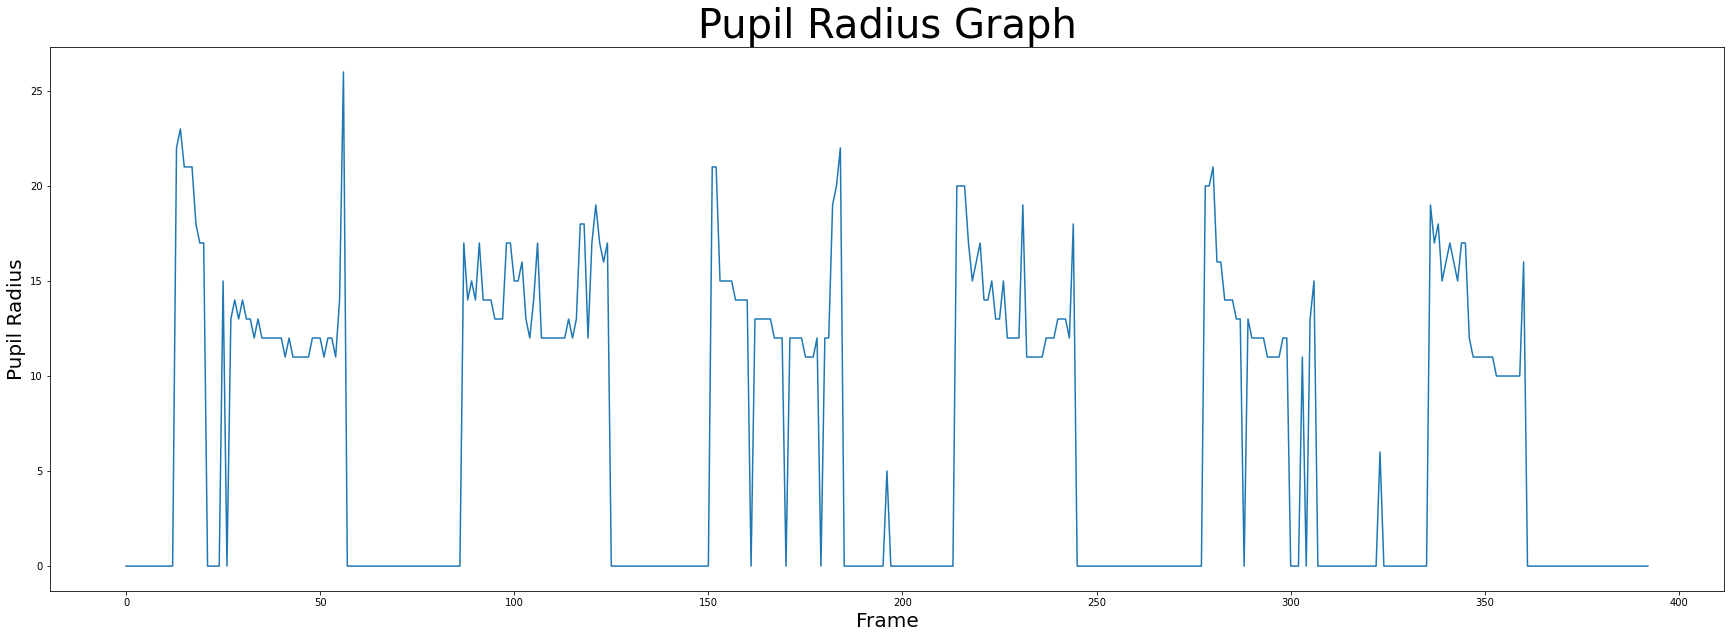

In [41]:

# 동공 크기 그래프
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))
plt.plot(np.array(range(0,rads.size)),rads)
plt.xlabel('Frame',fontsize=20)
plt.ylabel('Pupil Radius',fontsize=20)
plt.title('Pupil Radius Graph',fontsize=40)
plt.show

In [30]:
vid_img=[]
for i in range(1,count):
    vid_img.append(cv2.imread("processed_data/data_0725/processed_video_1/image{}.jpg".format(str(i).zfill(3))))
h,w,layers=vid_img[1].shape

vid=cv2.VideoWriter("processed_data/data_0725/processed_video_1/result_1.mp4", cv2.VideoWriter_fourcc('F','M','P','4'),23,(h, w))

for j in range(0,count-1):
    vid.write(vid_img[j])
vid.release()